Starting from [02:46:52](https://www.youtube.com/watch?v=l8pRSuU81PU&t=10012s)
- This note book is just to show the steps and required changes in order. To run the `DDP.py` you should run `torchrun` command as shown
- You should also have multiple GPUs to run this code
- I recommend checking this [video](https://www.youtube.com/watch?v=Cvdhwx-OBBo)

In [4]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time
import math

# DDP Setup

In [16]:
from torch.distributed import init_process_group, destroy_process_group
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import os

In [10]:
# torchrun command sets the env vars RANK, LOCAL_RANK, and WORLD_SIZE
ddp = int(os.environ.get("RANK", -1)) != -1  # is this a distributed run or not
if ddp:
    # you should be using cuda
    assert torch.cuda.is_available()
    init_process_group("nccl")  # initialize the process group
    ddp_rank = int(
        os.environ["RANK"]
    )  # GPU 0 have rank of 0, GPU 1 have rank of 1, etc.
    ddp_local_rank = int(
        os.environ["LOCAL_RANK"]
    )  # Rank of the GPU on the node (we have a single node)
    ddp_world_size = int(os.environ["WORLD_SIZE"])  # world size is the number of GPUs
    device = torch.device(f"cuda:{ddp_local_rank}")
    torch.cuda.set_device(device)
    master_process = (
        ddp_rank == 0
    )  # process 0 some additional work. It's responsible for logging, saving checkpoints, etc.
else:
    # single GPU
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    device = "cuda"
    master_process = True # single GPU, so we are the master process

# Change the gradient accumulation steps

```
torchrun --nproc_per_node=4 --master_addr=192.168.122.247 --master_port=29500 DDP.py
```

In [11]:
total_batch_size = 2**19
B = 16  # micro batch size
T = 1024  # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0  # total batch size must be divisible by B * T * world size
grad_accum_steps = total_batch_size // (B * T * ddp_world_size) # divide by world size to distribute the batch over all GPUs
# print only if master process
if master_process:
    print(
        f"total desired batch size: {total_batch_size:,}, grad_accum_steps: {grad_accum_steps:,}"
    )

total desired batch size: 524,288, grad_accum_steps: 32


# Testing the DDP setup

In [ ]:
# add some logging
print(f"I'm GPU: {ddp_rank}\nByeb")

First, you must make sure you have multiple GPUs available. You can check this by running `nvidia-smi` in the terminal. You should see something like this:

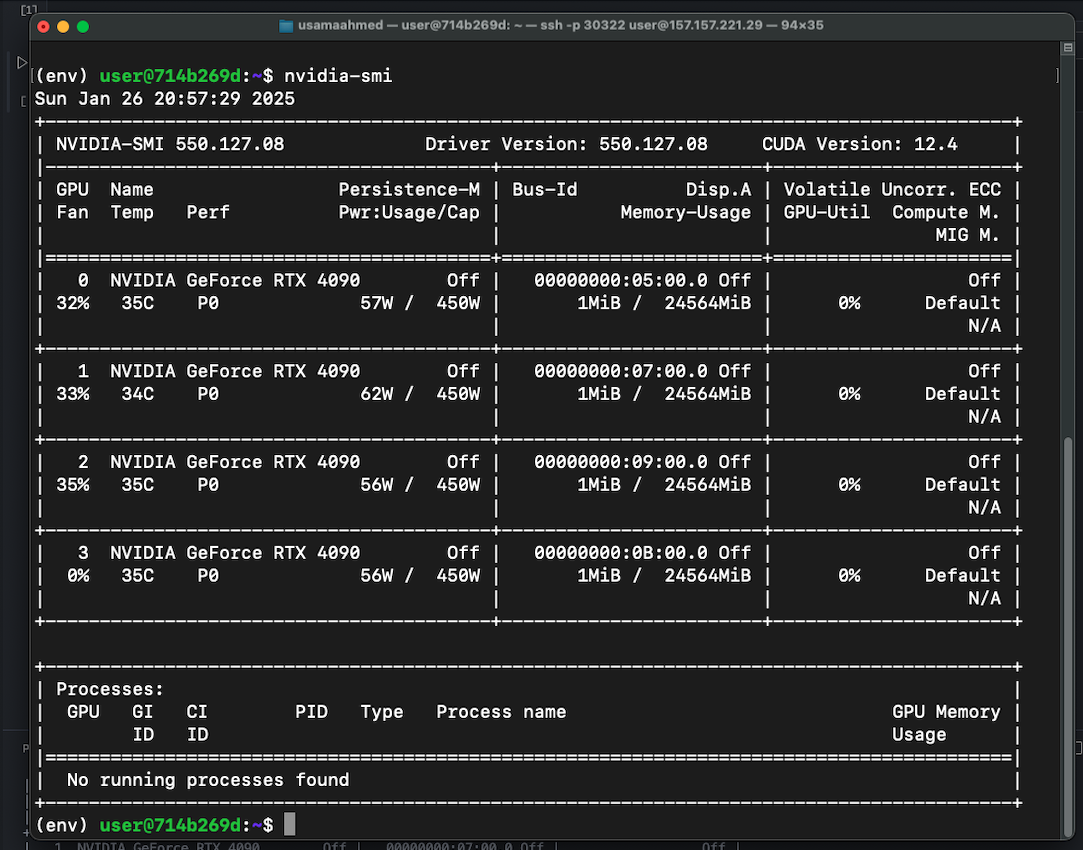

Combine the previous code into a single python file and run it using
```bash
torchrun --standalone --nproc_per_node=<number of GPUs> <filename>.py
```
in my case I have 4x4090 GPUs so I will run
```bash
torchrun --standalone --nproc_per_node=4 DDP.py
```
The output should be something like
```
total desired batch size: 524,288, grad_accum_steps: 8
I'm GPU: 0
Bye
I'm GPU: 2
Bye
I'm GPU: 1
Bye
I'm GPU: 3
Bye
```

# Modify the dataloader

In [13]:
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes

        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)

        # Process rank 0 will start at 0
        # Process rank 1 will start at B * T
        # Process rank 2 will start at 2 * B * T 
        # etc.
        self.current_position = self.B * self.T * self.process_rank 

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + (B * T) + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        self.current_position += B * T * self.num_processes
        # reset if we reach the end
        if self.current_position + (B * T * self.num_processes) + 1 > len(self.tokens):
            self.current_position = self.B * self.T * self.process_rank
        return x, y

In [14]:
train_loader = DataLoaderLite(B, T, ddp_rank, ddp_world_size)

# Prepare models

In [ ]:
# Set fixed seed (to create identical models for all processes)
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

In [ ]:
# initialize the model as before
model = GPT(GPTConfig(vocab_size = 50304)) 
model = model.to(device)
model = torch.compile(model)
# if ddp you must wrap the model in DDP
if ddp:
    model = DDP(model, device_ids = [ddp_local_rank]) # To combine the gradients from all GPUs into one

# Training Loop

## Avoid loss synchronization after each micro step

In [ ]:
times = []
train_loader = DataLoaderLite(B, T)
optimizer = model.configure_optimizers(0.1, 6e-4, "cuda")
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to("cuda"), y.to("cuda")
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss /= (
            grad_accum_steps  # divide by grad_accum_steps since the reduction is mean
        )
        loss_accum += loss.detach()
        # The loss is synchronized across all GPUs for each microsetp. This is wasteful.
        if ddp:
            # equivalent to using `no_sync` context manager
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1) # turn on only if it's the last microstep
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss_accum)
    print(
        f"Step {step}, Loss: {loss_accum}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
    )
    times.append(t1 - t0)


## Calculation of `loss_accum` and accessing `configure_optimizers`
The current implementation prints the loss of the master process only

In [ ]:
times = []
train_loader = DataLoaderLite(B, T)
# You must add this to access the function `configure_optimizers` on the model when using DDP
if ddp:
    optimizer = model.module.configure_optimizers(0.1, 6e-4, "cuda")
else:
    optimizer = model.configure_optimizers(0.1, 6e-4, "cuda")
losses = []
for step in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to("cuda"), y.to("cuda")
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss /= (
            grad_accum_steps  # divide by grad_accum_steps since the reduction is mean
        )
        loss_accum += loss.detach()
        # The loss is synchronized across all GPUs for each microsetp. This is wasteful.
        if ddp:
            # equivalent to using `no_sync` context manager
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1) # turn on only if it's the last microstep
        loss.backward()
    if ddp:
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)  # avg the loss across all GPUs
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set lr for the current iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss_accum)
    if master_process:
        print(
            f"Step {step}, Loss: {loss_accum}, lr: {lr:.4e}, norm: {norm:.4f}, Time: {(t1 - t0 )* 1000:.3f}ms"
        )
    times.append(t1 - t0)

In [ ]:
# Destroy the process group
if ddp:
    destroy_process_group()

# Running the full version

Running the current `DDP.py` file should work now and you should see the loss of each step (printed from the master GPU only)
```
total desired batch size: 524,288, grad_accum_steps: 8
num ecayed parameter tensors: 50 with 124,354,560 params
num non-decayed parameter tensors: 98 with 121,344 params
Step 0, Loss: 10.938562393188477, lr: 6.0000e-05, norm: 27.8114, Time: 30077.032ms
Step 1, Loss: 9.658305168151855, lr: 1.2000e-04, norm: 9.5734, Time: 1660.915ms
Step 2, Loss: 9.206701278686523, lr: 1.8000e-04, norm: 5.8513, Time: 1636.579ms
...
Step 47, Loss: 5.683640480041504, lr: 6.7460e-05, norm: 0.1617, Time: 1634.189ms
Step 48, Loss: 5.677981376647949, lr: 6.3324e-05, norm: 0.1940, Time: 1635.509ms
Step 49, Loss: 5.677218914031982, lr: 6.0832e-05, norm: 0.1826, Time: 1636.835ms
```